## Event Analysis Notebook

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
from tabulate import tabulate
import networkx as nx
import itertools
import analysis_functions

In [2]:
### Load Data 
voteData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\votes.csv')
groupData = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\users_to_groups.csv')
forumQuestions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\forum_questions.csv')
groupCategories = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\group_categories.csv')
questionOptions = pd.read_csv(r'C:\Users\beneb\Desktop\plural_data\question_options.csv')

# print("voteData:", len(voteData))
# print("groupData:", len(groupData))
# print("forumQuestions:", len(forumQuestions))
# print("groupCategories:", len(groupCategories))

### Manual Analysis

In [3]:
# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# Specify an option id
option_id = '4ad65252-e651-460c-af6b-289769a3964b'

In [4]:
# Analysis of a given option id 
votes = analysis_functions.get_latest_vote_by_user_and_optionid(voteData, option_id)
filtered_votes = analysis_functions.filter_zero_votes(votes)
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, group_categories)
groups = analysis_functions.get_groups_by_user_and_optionid(groupData, filtered_votes, group_categories_ids)
memberships = analysis_functions.create_group_memberships(groups)
filtered_groups = analysis_functions.remove_duplicate_groups(groups)
plurality_score = analysis_functions.connection_oriented_cluster_match(filtered_groups, filtered_votes)

# print("votes:", votes)
# print("filtered_votes:", filtered_votes)
# print("group_categories_ids:", group_categories_ids)
# print("groups:", groups)
# print("memberships:", memberships)
# print("filtered_groups:", filtered_groups)
# print("plurality_score:", plurality_score)

### Voting Results Table  

In [86]:
# specify a question id 
question_id = '5eaea820-8b02-446c-bf17-59f6fc1799bc'

# Specify group categories to be considered for the analysis (at least 'affiliation' must be specified)
group_categories = ['affiliation', 'private']

# get list of option ids related to the question id 
optionIds = questionOptions[questionOptions['question_id'] == question_id]['id'].tolist()

['affiliation', 'private']


In [6]:
# Generate Results 
results_dict = analysis_functions.get_results_dict(optionIds, voteData, groupData, groupCategories, group_categories)

# add a rank to each result category (plural score, raw votes, quadratic score)
results_dict_with_ranks = analysis_functions.calculate_ranks(results_dict)

# Sort results according to the plurality score
sorted_results_dict_with_ranks = dict(sorted(results_dict_with_ranks.items(), key=lambda item: item[1]['pluralityScore']['score'], reverse=True))

In [7]:
# Create data table 
table_data = []
headers = ['Options', 'Plurality Score', 'Quadratic Score', 'Raw Votes']

option_counter = 1

for option, data in sorted_results_dict_with_ranks.items():
    row = [f'Option {option_counter}']
    for category in ['pluralityScore', 'quadraticScore', 'totalRawVotes']:
        row.append(round(data[category]['score'], 3))
    table_data.append(row)
    option_counter += 1 

df = pd.DataFrame(table_data, columns=headers)

In [8]:
# Save and Print results 
df.to_excel('plots-and-tables/voting_results.xlsx', index=False)
print(tabulate(df, headers='keys', tablefmt='pretty'))

+----+-----------+-----------------+-----------------+-----------+
|    |  Options  | Plurality Score | Quadratic Score | Raw Votes |
+----+-----------+-----------------+-----------------+-----------+
| 0  | Option 1  |      59.45      |     64.658      |    213    |
| 1  | Option 2  |     42.394      |     43.858      |    196    |
| 2  | Option 3  |     39.655      |     50.425      |    263    |
| 3  | Option 4  |     38.545      |     41.391      |    124    |
| 4  | Option 5  |     36.083      |     37.335      |    124    |
| 5  | Option 6  |     36.031      |     37.566      |    110    |
| 6  | Option 7  |     32.766      |     31.035      |    82     |
| 7  | Option 8  |      30.99      |     32.565      |    86     |
| 8  | Option 9  |     27.541      |     28.423      |    60     |
| 9  | Option 10 |     27.254      |     28.397      |    82     |
| 10 | Option 11 |     25.808      |     25.104      |    64     |
| 11 | Option 12 |     25.604      |      26.75      |    67  

### Result Visualizations

#### Ranking Distribution

In [9]:
# Define the categories and custom labels for the x-axis
categories = ['pluralityScore', 'quadraticScore', 'totalRawVotes']
custom_labels = ['Plurality Score Rank', 'Quadratic Score Rank', 'Raw Votes Rank']

# Get the number of options
num_options = len(sorted_results_dict_with_ranks)

# Get a list of distinct colors
colors = list(TABLEAU_COLORS.values())

# Ensure enough colors for all options, if not, repeat the colors
while len(colors) < num_options:
    colors.extend(colors)

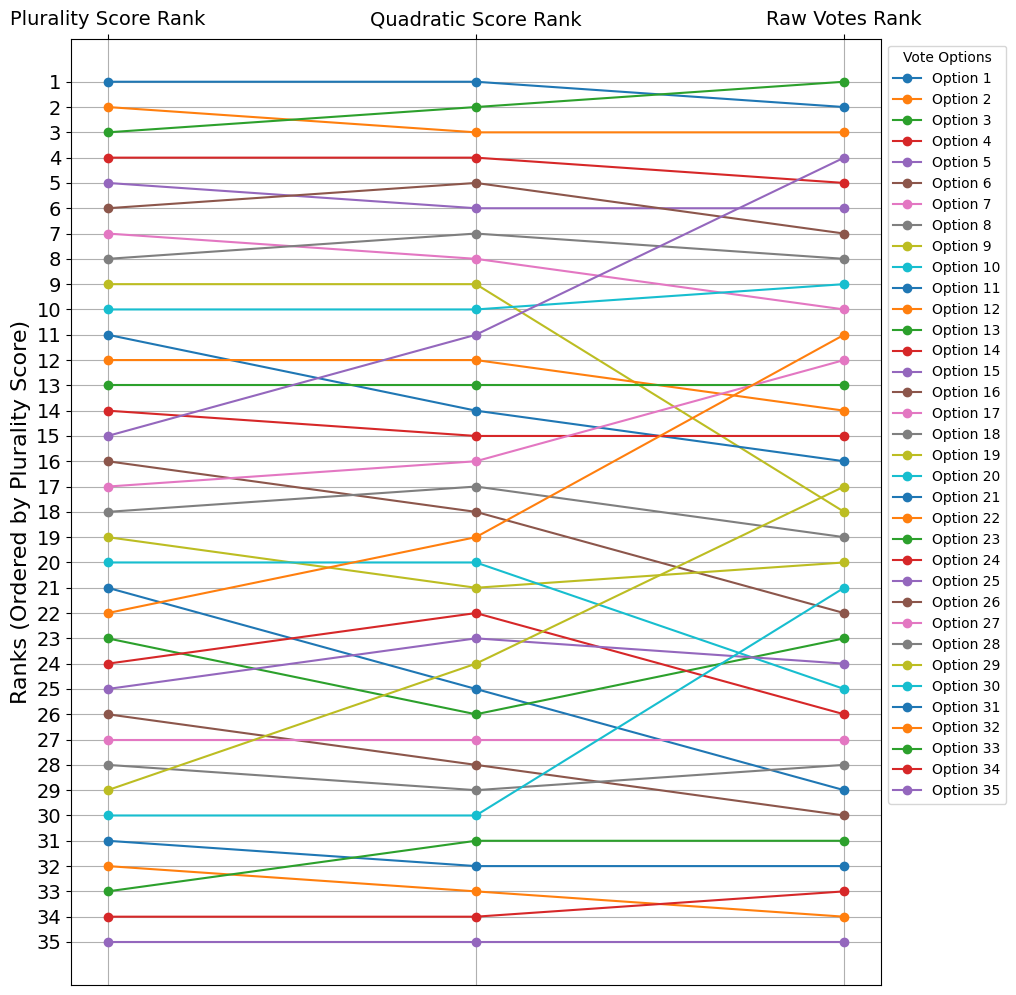

In [10]:
# Bump Chart 
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=colors[i])

plt.gca().invert_yaxis() 
plt.yticks(range(1, max(ranks) + 1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels)
plt.tight_layout()
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart.png')

#### Highlighted Ranking Distribution

In [11]:
# Calculate the absolute difference in ranks for each ranking category
rank_diff = {}
for option, option_data in sorted_results_dict_with_ranks.items():
    ranks = [option_data[category]['rank'] for category in categories]
    diff = max(ranks) - min(ranks)
    rank_diff[option] = diff

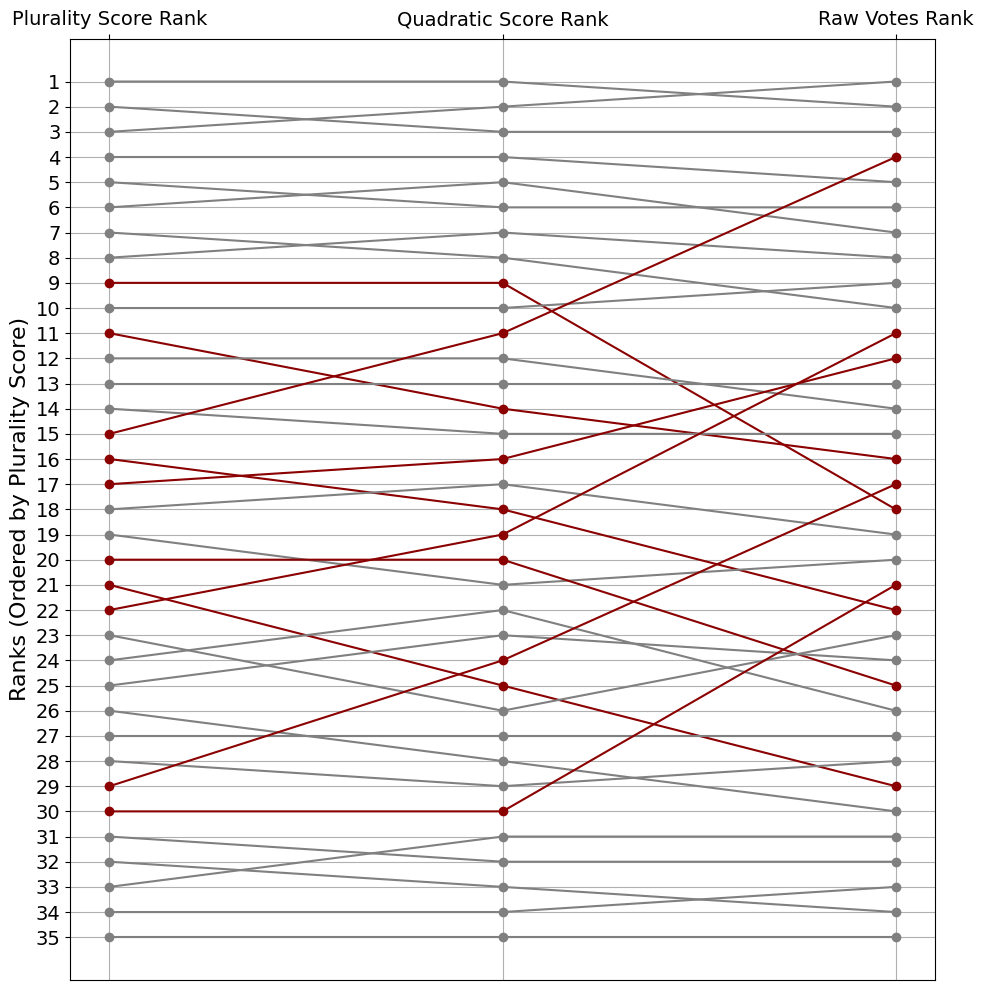

In [12]:
# Bump chart highlighting large differences in the ranking distribution
plt.figure(figsize=(10, 10))

for i, (option, option_data) in enumerate(sorted_results_dict_with_ranks.items()):
    ranks = [option_data[category]['rank'] for category in categories]
    if rank_diff[option] > 4:
        color = 'darkred'
    else:
        color = 'gray'
    plt.plot(categories, ranks, marker='o', label=f'Option {i+1}', color=color)

plt.gca().invert_yaxis()
plt.yticks(range(1, max(ranks) + 1))
plt.gca().tick_params(axis='y', labelsize=14)
plt.gca().tick_params(axis='x', labelsize=14)
plt.xlabel('', fontsize=16)
plt.ylabel('Ranks (Ordered by Plurality Score)', fontsize=16)
plt.title('', fontsize=16)
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Vote Options')  # Include legend title
plt.grid(True)
plt.gca().xaxis.tick_top()
plt.gca().set_xticks(range(len(categories)))
plt.gca().set_xticklabels(custom_labels, fontsize=14)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('plots-and-tables/bump_chart_without_legend.png')

### Network Visualization

In [123]:
# filter group data by users who voted and by relevant group categories 
distinct_user_ids = voteData['user_id'].unique().tolist()
filtered_group_users = groupData[groupData['user_id'].isin(distinct_user_ids)]
group_categories_ids = analysis_functions.get_group_categories_ids(groupCategories, names=['affiliation', 'private'])
filtered_group_users_categories = filtered_group_users[filtered_group_users['group_category_id'].isin(group_categories_ids)]

print("Number of unique users:", filtered_group_users['user_id'].nunique())
print("Number of group categories:", filtered_group_users_categories['group_category_id'].nunique())
print("Length of group data:", len(filtered_group_users_categories))

Number of unique users: 36
Number of group categories: 2
Length of group data: 60


In [124]:
# Bipartite graph 
filtered_group_users_categories.sort_values(by='user_id').head()

,id,user_id,group_id,created_at,updated_at,group_category_id
100,ad452265-f19e-41e6-969c-4aab2db06a20,03aaaaa7-04f7-4c50-9471-7fc8a91adb98,5a339142-3ff3-4c11-9c5d-fd84878e164b,2024-05-28T06:50:20.574Z,2024-05-28T06:50:20.574Z,0419db52-cda8-4cf2-adb2-a881234ea1f8
17,733ee2b1-6d2e-4110-9956-e49d8fe282b9,03e5cafe-075a-4085-9e4d-3f960bb04219,28317618-cd94-49c5-9662-dee37e14970b,2024-04-17T10:01:04.933Z,2024-05-28T05:42:49.474Z,0419db52-cda8-4cf2-adb2-a881234ea1f8
68,54bf61e2-ffc2-44ca-ad06-06075fff6e36,05d7780a-aa90-4cc4-b82c-74e121e11c90,6bffe6f8-e3ea-44c2-8b34-a840374d79de,2024-03-19T18:58:05.558Z,2024-03-19T18:58:05.558Z,0419db52-cda8-4cf2-adb2-a881234ea1f8
14,62057675-8f7a-4b40-9290-8a6574694ee7,0ae4ca12-23e6-44b5-ba9e-7dcb630270d5,d7c66736-d56b-4bb1-a70f-bf05ee739169,2024-03-11T16:02:32.899Z,2024-05-28T05:36:59.026Z,0419db52-cda8-4cf2-adb2-a881234ea1f8
22,8e0bd72b-0aaf-49cf-9a44-981146a6c19c,0f8e54b6-bd20-41d0-8957-143af5572483,2d4a0d29-4a70-40e8-9218-a6fa79769778,2024-05-28T06:01:33.251Z,2024-05-28T06:01:33.251Z,0419db52-cda8-4cf2-adb2-a881234ea1f8


In [125]:
# Group by 'user_id' and aggregate 'group_id' and 'group_category_id' into lists
reduced_filtered_group_users_categories = filtered_group_users_categories.groupby('user_id').agg({'group_id': list, 'group_category_id': list}).reset_index()
reduced_filtered_group_users_categories.head()

,user_id,group_id,group_category_id
0,03aaaaa7-04f7-4c50-9471-7fc8a91adb98,[5a339142-3ff3-4c11-9c5d-fd84878e164b],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
1,03e5cafe-075a-4085-9e4d-3f960bb04219,[28317618-cd94-49c5-9662-dee37e14970b],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
2,05d7780a-aa90-4cc4-b82c-74e121e11c90,[6bffe6f8-e3ea-44c2-8b34-a840374d79de],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
3,0ae4ca12-23e6-44b5-ba9e-7dcb630270d5,[d7c66736-d56b-4bb1-a70f-bf05ee739169],[0419db52-cda8-4cf2-adb2-a881234ea1f8]
4,0f8e54b6-bd20-41d0-8957-143af5572483,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8]


In [126]:
print("Number of groups:", filtered_group_users_categories['group_id'].nunique())

Number of groups: 29


In [128]:
# Create a DataFrame from filtered_groupData
df = pd.DataFrame(filtered_group_users_categories)

# Group DataFrame by group_id
grouped = df.groupby('group_id')

# Initialize an empty list to store edges
edge_list = []

# Iterate over groups
for group_id, group_data in grouped:
    # Create pairs of users within the group
    for i in range(len(group_data)):
        for j in range(i + 1, len(group_data)):
            edge_list.append({'source': group_data.iloc[i]['user_id'], 'target': group_data.iloc[j]['user_id']})

# Convert the edge list to a DataFrame
edge_df = pd.DataFrame(edge_list)

# Create a set of all unique user IDs
all_user_ids = set(df['user_id'])

# Create a node list containing all user IDs
node_list = [{'id': user_id} for user_id in all_user_ids]

In [129]:
unique_user_ids = set(edge_df['source']).union(edge_df['target'])
print(len(unique_user_ids))

30


In [130]:
edge_df.head()

,source,target
0,33444574-71e7-4199-b474-a7e8c5df392d,0f8e54b6-bd20-41d0-8957-143af5572483
1,33444574-71e7-4199-b474-a7e8c5df392d,becbf23b-3cde-430b-b43a-2dcd6581a99c
2,33444574-71e7-4199-b474-a7e8c5df392d,7b3703c0-d208-4f49-a798-8aec432e962e
3,0f8e54b6-bd20-41d0-8957-143af5572483,becbf23b-3cde-430b-b43a-2dcd6581a99c
4,0f8e54b6-bd20-41d0-8957-143af5572483,7b3703c0-d208-4f49-a798-8aec432e962e


In [131]:
# Merge the edge_df with reduced_filtered_group_users_categories on source and target user_id
merged_df = pd.merge(edge_df, reduced_filtered_group_users_categories, left_on='source', right_on='user_id', suffixes=('', '_source'))
merged_df = pd.merge(merged_df, reduced_filtered_group_users_categories, left_on='target', right_on='user_id', suffixes=('', '_target'))

# Define function to find common groups and group categories
def find_shared_groups_and_categories(row):
    source_groups = set(row['group_id'])
    target_groups = set(row['group_id_target'])
    shared_groups = source_groups.intersection(target_groups)
    
    shared_group_categories = []
    for group in shared_groups:
        source_category = row['group_category_id'][row['group_id'].index(group)]
        target_category = row['group_category_id_target'][row['group_id_target'].index(group)]
        if source_category == target_category:
            shared_group_categories.append(source_category)
        else:
            shared_group_categories.extend([source_category, target_category])
    
    return pd.Series([list(shared_groups), list(set(shared_group_categories))])

# Apply the function to each row and create new columns 'shared_groups' and 'shared_group_categories'
merged_df[['shared_groups', 'shared_group_categories']] = merged_df.apply(find_shared_groups_and_categories, axis=1)

# Define function to determine edge attribute
def determine_edge_attribute(shared_group_categories):
    shared_categories_set = set(shared_group_categories)
    if '0419db52-cda8-4cf2-adb2-a881234ea1f8' in shared_categories_set and 'b1862f74-458c-4eb8-9445-1ccf9ccd1712' in shared_categories_set:
        return 'both'
    elif shared_categories_set == {'0419db52-cda8-4cf2-adb2-a881234ea1f8'}:
        return 'affiliation'
    elif shared_categories_set == {'b1862f74-458c-4eb8-9445-1ccf9ccd1712'}:
        return 'private'
    return None

# Apply the function to determine 'edge_attribute'
merged_df['edge_attribute'] = merged_df['shared_group_categories'].apply(determine_edge_attribute)

# Display the final DataFrame
merged_df.head()


,source,target,user_id,group_id,group_category_id,user_id_target,group_id_target,group_category_id_target,shared_groups,shared_group_categories,edge_attribute
0,33444574-71e7-4199-b474-a7e8c5df392d,0f8e54b6-bd20-41d0-8957-143af5572483,33444574-71e7-4199-b474-a7e8c5df392d,"[2d4a0d29-4a70-40e8-9218-a6fa79769778, f6f5f6a...","[0419db52-cda8-4cf2-adb2-a881234ea1f8, b1862f7...",0f8e54b6-bd20-41d0-8957-143af5572483,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],affiliation
1,33444574-71e7-4199-b474-a7e8c5df392d,becbf23b-3cde-430b-b43a-2dcd6581a99c,33444574-71e7-4199-b474-a7e8c5df392d,"[2d4a0d29-4a70-40e8-9218-a6fa79769778, f6f5f6a...","[0419db52-cda8-4cf2-adb2-a881234ea1f8, b1862f7...",becbf23b-3cde-430b-b43a-2dcd6581a99c,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],affiliation
2,0f8e54b6-bd20-41d0-8957-143af5572483,becbf23b-3cde-430b-b43a-2dcd6581a99c,0f8e54b6-bd20-41d0-8957-143af5572483,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],becbf23b-3cde-430b-b43a-2dcd6581a99c,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],affiliation
3,33444574-71e7-4199-b474-a7e8c5df392d,7b3703c0-d208-4f49-a798-8aec432e962e,33444574-71e7-4199-b474-a7e8c5df392d,"[2d4a0d29-4a70-40e8-9218-a6fa79769778, f6f5f6a...","[0419db52-cda8-4cf2-adb2-a881234ea1f8, b1862f7...",7b3703c0-d208-4f49-a798-8aec432e962e,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],affiliation
4,0f8e54b6-bd20-41d0-8957-143af5572483,7b3703c0-d208-4f49-a798-8aec432e962e,0f8e54b6-bd20-41d0-8957-143af5572483,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],7b3703c0-d208-4f49-a798-8aec432e962e,[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],[2d4a0d29-4a70-40e8-9218-a6fa79769778],[0419db52-cda8-4cf2-adb2-a881234ea1f8],affiliation


In [134]:
edge_df_new = merged_df[['source', 'target', 'edge_attribute']]
print(edge_df_new.head())
# edge_df_new.to_excel('plots-and-tables/edge_df_new.xlsx', index=False)

                                 source                                target  \
0  33444574-71e7-4199-b474-a7e8c5df392d  0f8e54b6-bd20-41d0-8957-143af5572483   
1  33444574-71e7-4199-b474-a7e8c5df392d  becbf23b-3cde-430b-b43a-2dcd6581a99c   
2  0f8e54b6-bd20-41d0-8957-143af5572483  becbf23b-3cde-430b-b43a-2dcd6581a99c   
3  33444574-71e7-4199-b474-a7e8c5df392d  7b3703c0-d208-4f49-a798-8aec432e962e   
4  0f8e54b6-bd20-41d0-8957-143af5572483  7b3703c0-d208-4f49-a798-8aec432e962e   

  edge_attribute  
0    affiliation  
1    affiliation  
2    affiliation  
3    affiliation  
4    affiliation  


In [121]:
duplicate_edges = edge_df_new[edge_df_new.duplicated(subset=['target', 'source'], keep=False)]
duplicate_edges

,source,target,edge_attribute
11,e71aa119-5e1d-4e2b-a254-0d54a42bed46,9bf21665-d2fe-42e4-aa29-f764984a550b,both
12,e71aa119-5e1d-4e2b-a254-0d54a42bed46,9bf21665-d2fe-42e4-aa29-f764984a550b,both


In [139]:
import numpy as np

# Sorting the values in each row to ensure the order doesn't matter
edge_df_new[['source', 'target']] = pd.DataFrame(np.sort(edge_df_new[['source', 'target']], axis=1), index=edge_df_new.index)

# Finding duplicates
duplicates = edge_df_new[edge_df_new.duplicated(subset=['source', 'target'], keep=False)]

duplicates


C:\Users\beneb\AppData\Local\Temp\ipykernel_18160\3746565103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edge_df_new[['source', 'target']] = pd.DataFrame(np.sort(edge_df_new[['source', 'target']], axis=1), index=edge_df_new.index)


,source,target,edge_attribute
11,9bf21665-d2fe-42e4-aa29-f764984a550b,e71aa119-5e1d-4e2b-a254-0d54a42bed46,both
12,9bf21665-d2fe-42e4-aa29-f764984a550b,e71aa119-5e1d-4e2b-a254-0d54a42bed46,both
19,553c17da-097c-42aa-a70f-ed98430ab8d6,7c714603-5bb0-4bf0-b7f2-7119ded3aeb5,private
24,553c17da-097c-42aa-a70f-ed98430ab8d6,7c714603-5bb0-4bf0-b7f2-7119ded3aeb5,private
32,24aa77ce-e416-4170-800c-70fedbfa391d,cdbcdf8b-71cf-461e-af95-952ff205c68c,both
33,24aa77ce-e416-4170-800c-70fedbfa391d,576a0583-e429-414e-b52c-d98b06c29981,both
36,576a0583-e429-414e-b52c-d98b06c29981,cdbcdf8b-71cf-461e-af95-952ff205c68c,both
37,24aa77ce-e416-4170-800c-70fedbfa391d,576a0583-e429-414e-b52c-d98b06c29981,both
41,576a0583-e429-414e-b52c-d98b06c29981,cdbcdf8b-71cf-461e-af95-952ff205c68c,both
42,24aa77ce-e416-4170-800c-70fedbfa391d,cdbcdf8b-71cf-461e-af95-952ff205c68c,both


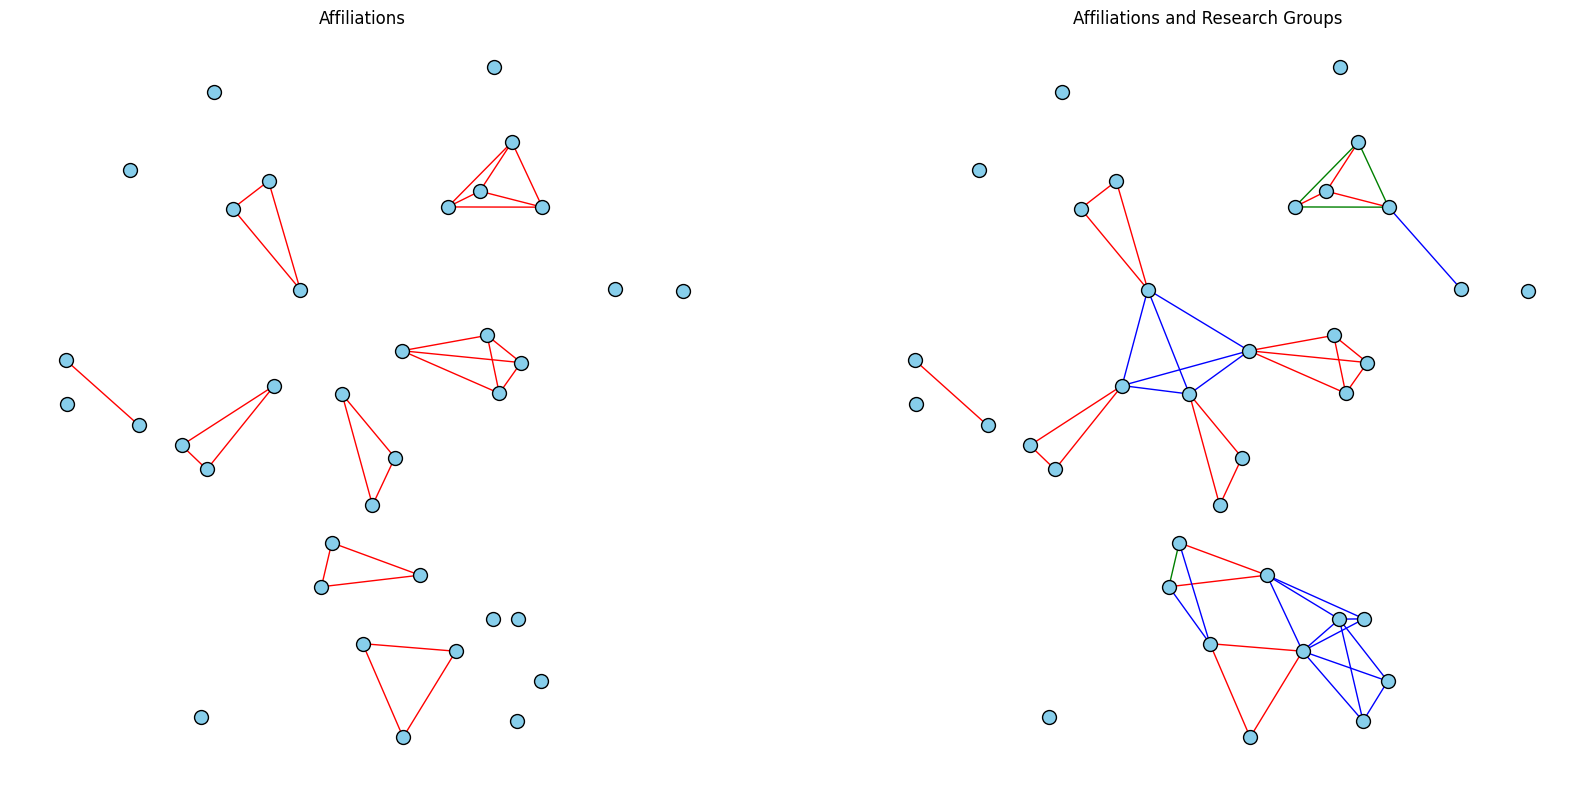

In [209]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 2: Edges colored based on their attributes using a colormap
G2 = nx.Graph()

# Add nodes from the DataFrame
G2.add_nodes_from([node['id'] for node in node_list])

# Add edges from the DataFrame
for _, row in edge_df_new.iterrows():
    G2.add_edge(row['source'], row['target'], edge_attribute=row['edge_attribute'])

# Use the Fruchterman-Reingold layout for positioning nodes
pos = nx.fruchterman_reingold_layout(G2, k=4, iterations=500, scale=1.5)

# Create a colormap based on edge attributes
edge_colors2 = []
edge_color_map = {'affiliation': 'red', 'private': 'blue', 'both': 'green'}
for edge in G2.edges():
    edge_attribute = G2[edge[0]][edge[1]]['edge_attribute']
    edge_colors2.append(edge_color_map[edge_attribute])

# Draw Graph 2 with colored edges
nx.draw(G2, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color=edge_colors2, ax=axes[1])
axes[1].set_title('Affiliations and Research Groups')

# Plot 1: Only "affiliation" and "both" edges, all in red
G1 = nx.Graph()
G1.add_nodes_from([node['id'] for node in node_list])
edges1 = [(row['source'], row['target']) for _, row in edge_df_new.iterrows() if row['edge_attribute'] in ['affiliation', 'both']]
G1.add_edges_from(edges1)

# Use the same layout positions as G2
pos = nx.fruchterman_reingold_layout(G1, pos=pos, fixed=pos.keys())

# Draw Graph 1 with red edges
nx.draw(G1, pos, with_labels=False, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color='red', ax=axes[0])
axes[0].set_title('Affiliations')

# Show the plots
plt.show()


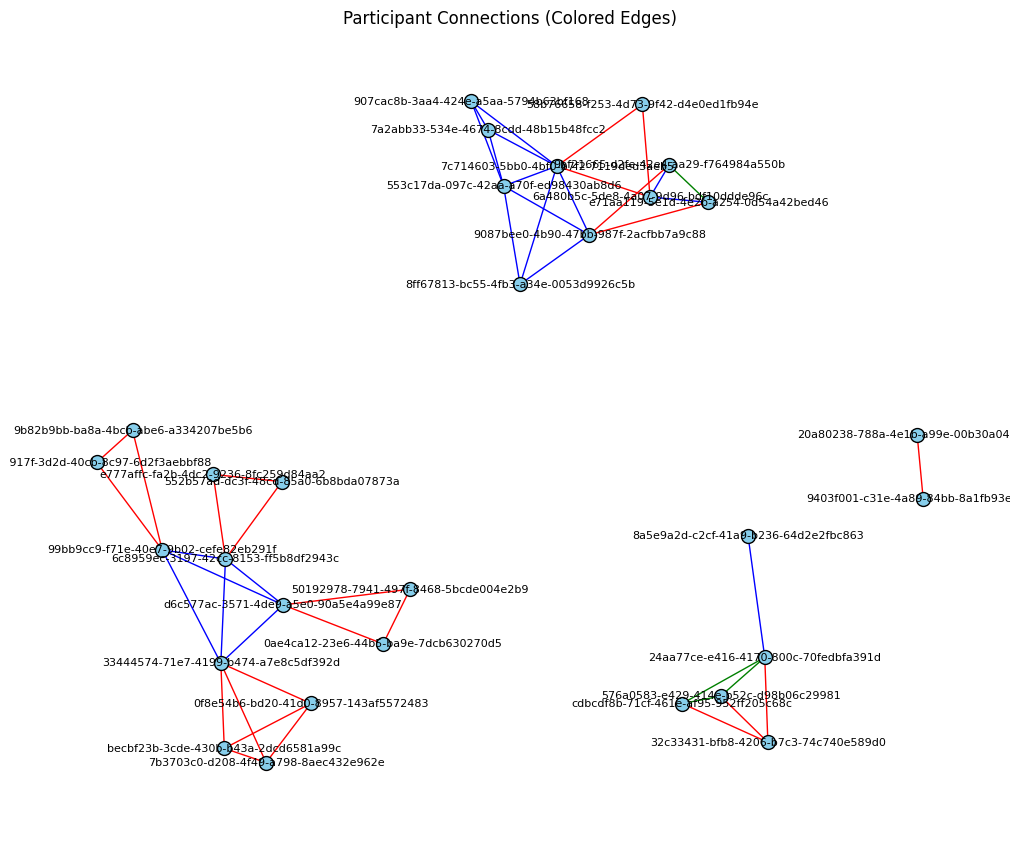

In [153]:
import matplotlib.pyplot as plt
import networkx as nx

# Create an empty graph
G2 = nx.Graph()

# Add nodes from the DataFrame
node_ids = set(edge_df_new['source']).union(set(edge_df_new['target']))
G2.add_nodes_from(node_ids)

# Add edges from the DataFrame
for _, row in edge_df_new.iterrows():
    G2.add_edge(row['source'], row['target'], edge_attribute=row['edge_attribute'])

# Create a spring layout for positioning nodes
pos = nx.spring_layout(G2, k=0.8, iterations=100, scale=2.0)

# Create a colormap based on edge attributes
edge_colors2 = []
edge_color_map = {'affiliation': 'red', 'private': 'blue', 'both': 'green'}
for edge in G2.edges():
    edge_attribute = G2[edge[0]][edge[1]]['edge_attribute']
    edge_colors2.append(edge_color_map[edge_attribute])

# Draw the graph with colored edges
plt.figure(figsize=(10, 8))
nx.draw(G2, pos, with_labels=True, node_size=100, node_color='skyblue', edgecolors='black', font_size=8, edge_color=edge_colors2)
plt.title('Participant Connections (Colored Edges)')
plt.show()
